Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# !apt-get install -y unzip

In [3]:
# !unzip x CNN_assignment.zip

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2248
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6876 files belonging to 9 classes.
Using 5501 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6876 files belonging to 9 classes.
Using 1375 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


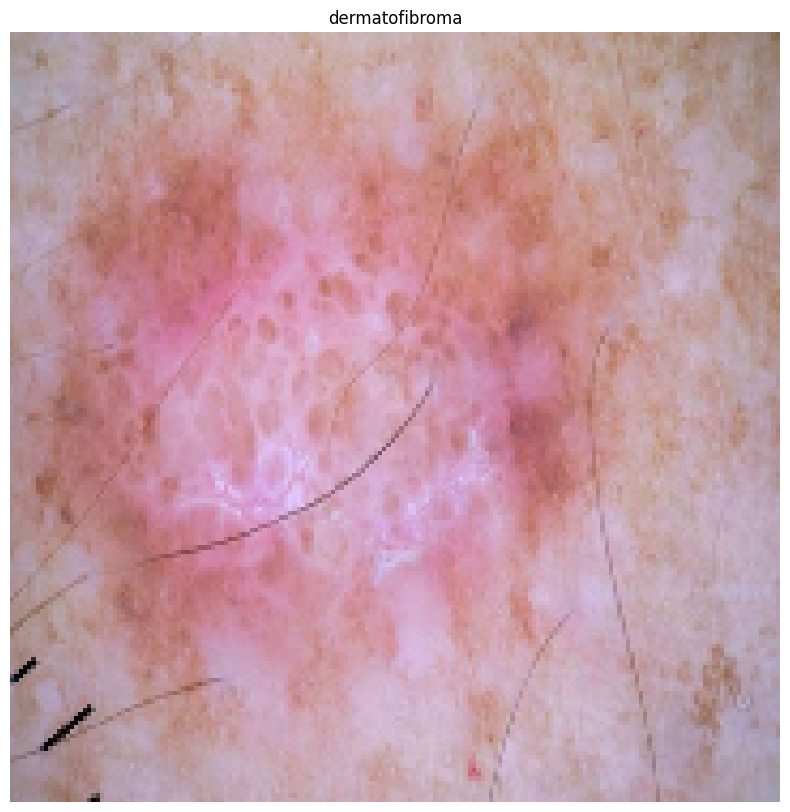

In [12]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

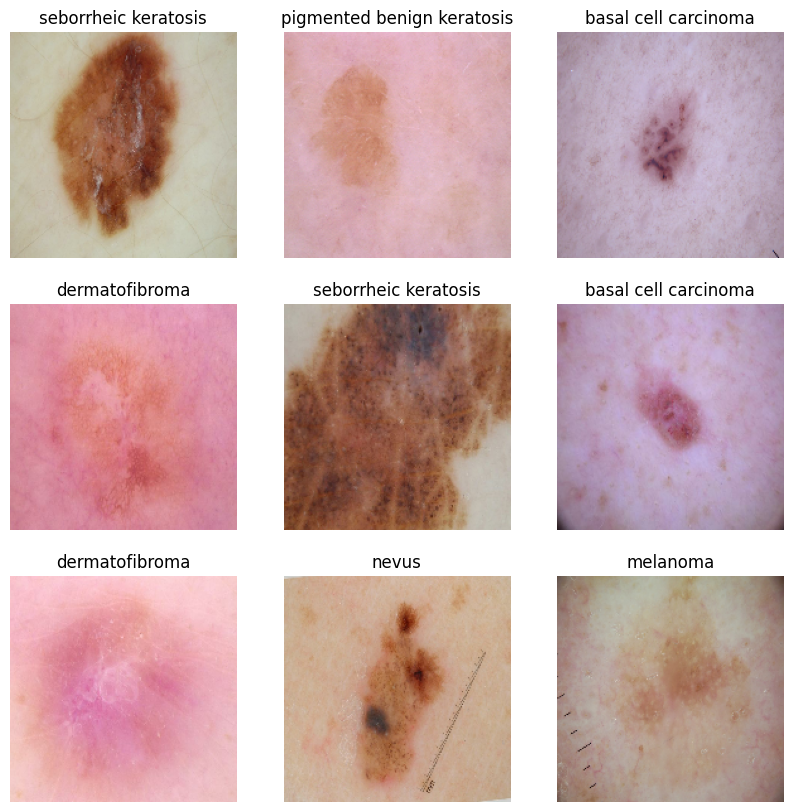

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
172/172 [==============================] - 38s 63ms/step - loss: 1.9368 - accuracy: 0.2663 - val_loss: 1.5494 - val_accuracy: 0.3971
Epoch 2/20
172/172 [==============================] - 3s 20ms/step - loss: 1.4598 - accuracy: 0.4383 - val_loss: 1.3425 - val_accuracy: 0.4960
Epoch 3/20
172/172 [==============================] - 4s 22ms/step - loss: 1.2845 - accuracy: 0.5181 - val_loss: 1.2352 - val_accuracy: 0.5367
Epoch 4/20
172/172 [==============================] - 3s 20ms/step - loss: 1.1422 - accuracy: 0.5773 - val_loss: 1.2290 - val_accuracy: 0.5520
Epoch 5/20
172/172 [==============================] - 3s 20ms/step - loss: 0.9878 - accuracy: 0.6453 - val_loss: 1.2581 - val_accuracy: 0.5542
Epoch 6/20
172/172 [==============================] - 4s 23ms/step - loss: 0.8673 - accuracy: 0.6866 - val_loss: 1.0938 - val_accuracy: 0.6204
Epoch 7/20
172/172 [==============================] - 4s 21ms/step - loss: 0.7449 - accuracy: 0.7353 - val_loss: 1.1331 - val_accuracy: 0.625

### Visualizing training results

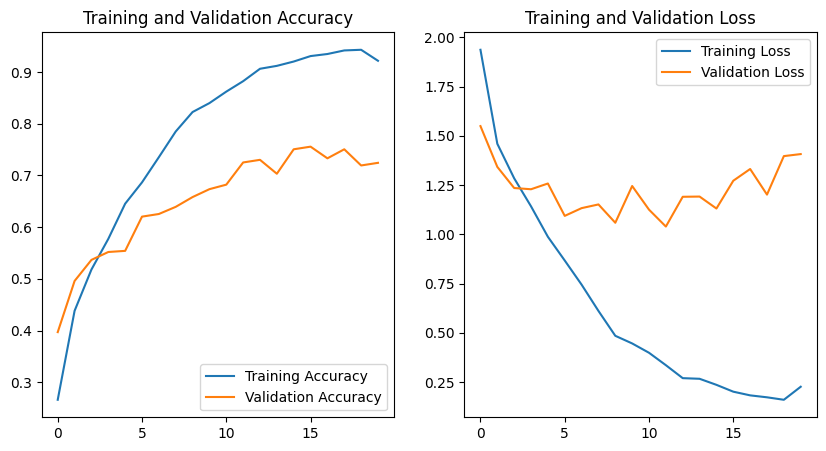

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The difference between the training and validation accuraccy indiates Overfitting.
- Also, we can see from the graph that with each epoch the traning loss is decreasing where as the validation loss is increasing, which is an indication of overfitting.


### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

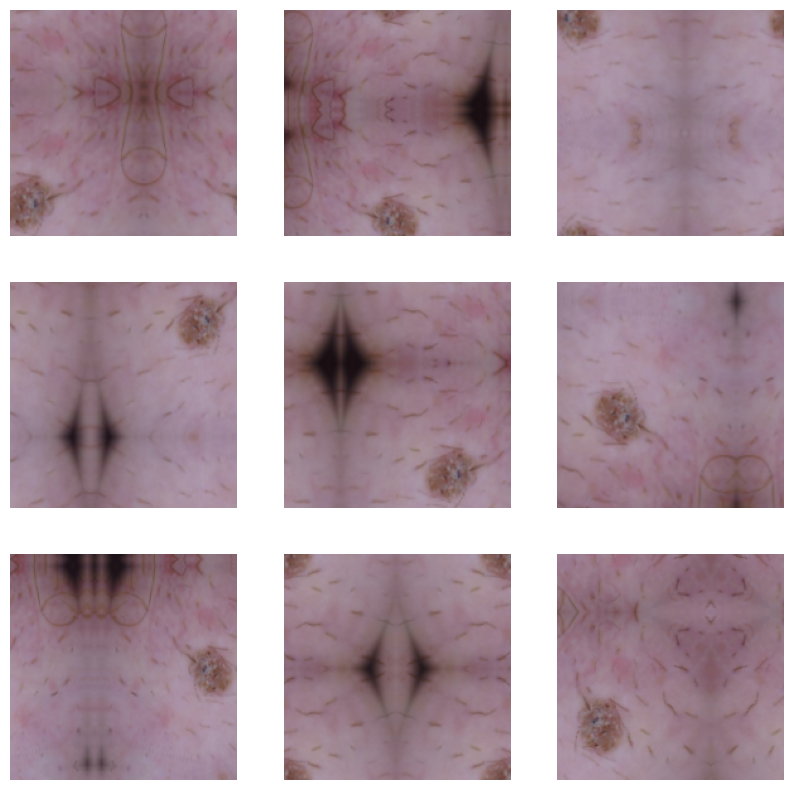

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
172/172 [==============================] - 31s 143ms/step - loss: 2.0296 - accuracy: 0.2091 - val_loss: 1.7938 - val_accuracy: 0.3004
Epoch 2/20
172/172 [==============================] - 21s 121ms/step - loss: 1.7581 - accuracy: 0.3030 - val_loss: 1.5986 - val_accuracy: 0.3745
Epoch 3/20
172/172 [==============================] - 21s 119ms/step - loss: 1.7312 - accuracy: 0.3149 - val_loss: 1.7642 - val_accuracy: 0.3236
Epoch 4/20
172/172 [==============================] - 20s 118ms/step - loss: 1.7027 - accuracy: 0.3247 - val_loss: 1.6043 - val_accuracy: 0.3484
Epoch 5/20
172/172 [==============================] - 20s 115ms/step - loss: 1.6197 - accuracy: 0.3561 - val_loss: 1.6001 - val_accuracy: 0.3724
Epoch 6/20
172/172 [==============================] - 20s 116ms/step - loss: 1.5771 - accuracy: 0.3803 - val_loss: 1.5975 - val_accuracy: 0.3600
Epoch 7/20
172/172 [==============================] - 19s 113ms/step - loss: 1.5579 - accuracy: 0.3814 - val_loss: 1.5124 - val_ac

### Visualizing the results

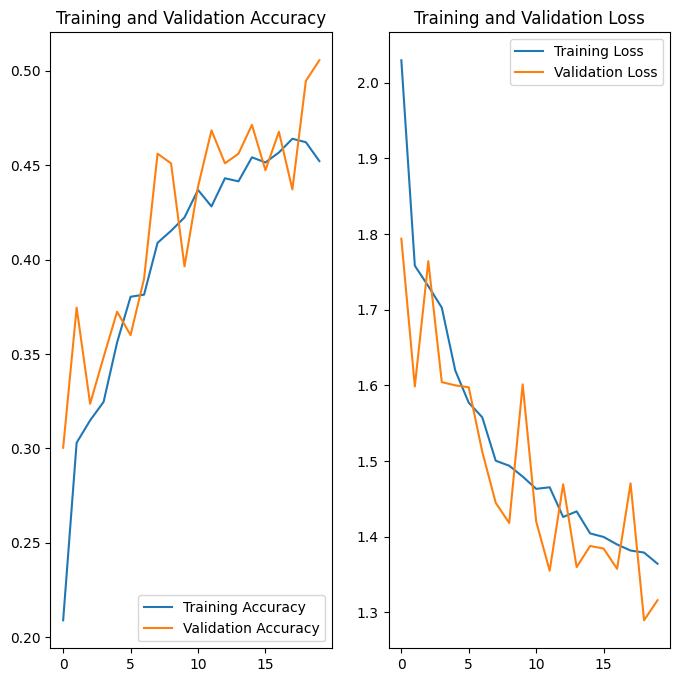

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- From the above graph we can see that traning and validation accuracy and loss and almost intersecting. So the agumentation has solved the problem of overfitting.
- But the overall accuracy/s are low for both training and valiation ds and losses and have gone up for both.
- Now we can try to increase the complexity of our model to improve accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2248

In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
1,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
2,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
3,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
4,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
...,...,...
2243,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis
2244,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis
2245,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis
2246,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis


Class=3, n=438 (19.484%)
Class=6, n=77 (3.425%)
Class=7, n=181 (8.052%)
Class=8, n=148 (6.584%)
Class=0, n=114 (5.071%)
Class=4, n=357 (15.881%)
Class=1, n=376 (16.726%)
Class=2, n=95 (4.226%)
Class=5, n=462 (20.552%)


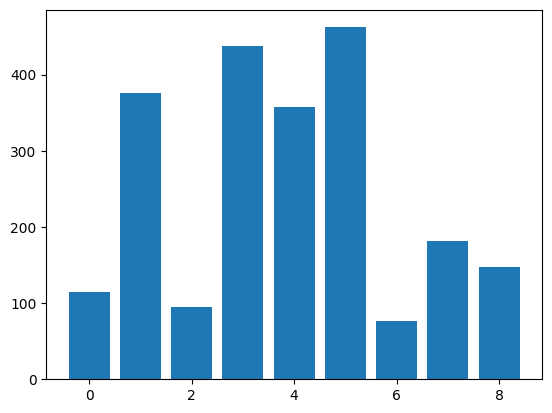

In [28]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(150) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBD5073BE80>: 100%|██████████| 150/150 [00:06<00:00, 23.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EBD561544C0>: 100%|██████████| 150/150 [00:07<00:00, 21.09 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBD5C472A40>: 100%|██████████| 150/150 [00:05<00:00, 26.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EBD5C472A10>: 100%|██████████| 150/150 [00:40<00:00,  3.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7EBD507D7E80>: 100%|██████████| 150/150 [00:22<00:00,  6.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EBD507E7CD0>: 100%|██████████| 150/150 [00:05<00:00, 26.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EBD50753F70>: 100%|██████████| 150/150 [00:12<00:00, 11.99 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBD5071EAA0>: 100%|██████████| 150/150 [00:04<00:00, 30.81 Samples/s]


Initialised with 148 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBD561571F0>: 100%|██████████| 150/150 [00:04<00:00, 32.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5978


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_b20b9d7f-4ca9-460b-8306-0e53ec8f4209.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0000432.jpg_97806594-edc5-451e-8cea-2551b062fc74.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0000522.jpg_d07a9ae5-9083-49ac-ba6f-53e08241d7b5.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0010007.jpg_53094e4c-50a6-47bd-84f4-ccd0d8d4c53c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0009992.jpg_4e012b2c-4a9e-4551-a7c0-2a9d4aba41ab.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0010878.jpg_e58d9bc3-52dc-4284-9a63-c7180b254f9b.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0000279.jpg_c4e122b5-9ebc-4bb1-981e-819f077b9d5c.jpg',
 '/con

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-35-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    1112
melanoma                      1088
basal cell carcinoma          1026
nevus                         1007
actinic keratosis              892
squamous cell carcinoma        831
vascular lesion                798
dermatofibroma                 745
seborrheic keratosis           727
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to
  image_size= (img_height, img_width),
  batch_size=batch_size)

Found 8226 files belonging to 9 classes.
Using 6581 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8226 files belonging to 9 classes.
Using 1645 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here 1
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [42]:
epochs = 50
## Your code goes here, use 50 epochs.
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
206/206 [==============================] - 52s 63ms/step - loss: 1.8606 - accuracy: 0.2837 - val_loss: 1.5327 - val_accuracy: 0.3994
Epoch 2/50
206/206 [==============================] - 6s 27ms/step - loss: 1.4401 - accuracy: 0.4580 - val_loss: 1.6338 - val_accuracy: 0.3994
Epoch 3/50
206/206 [==============================] - 6s 29ms/step - loss: 1.2696 - accuracy: 0.5189 - val_loss: 1.1612 - val_accuracy: 0.5495
Epoch 4/50
206/206 [==============================] - 7s 33ms/step - loss: 1.0957 - accuracy: 0.5949 - val_loss: 1.1285 - val_accuracy: 0.5897
Epoch 5/50
206/206 [==============================] - 6s 28ms/step - loss: 0.9233 - accuracy: 0.6616 - val_loss: 1.0288 - val_accuracy: 0.6170
Epoch 6/50
206/206 [==============================] - 6s 28ms/step - loss: 0.7833 - accuracy: 0.7181 - val_loss: 0.9690 - val_accuracy: 0.6729
Epoch 7/50
206/206 [==============================] - 5s 27ms/step - loss: 0.6500 - accuracy: 0.7671 - val_loss: 0.8839 - val_accuracy: 0.695

#### **Todo:**  Visualize the model results

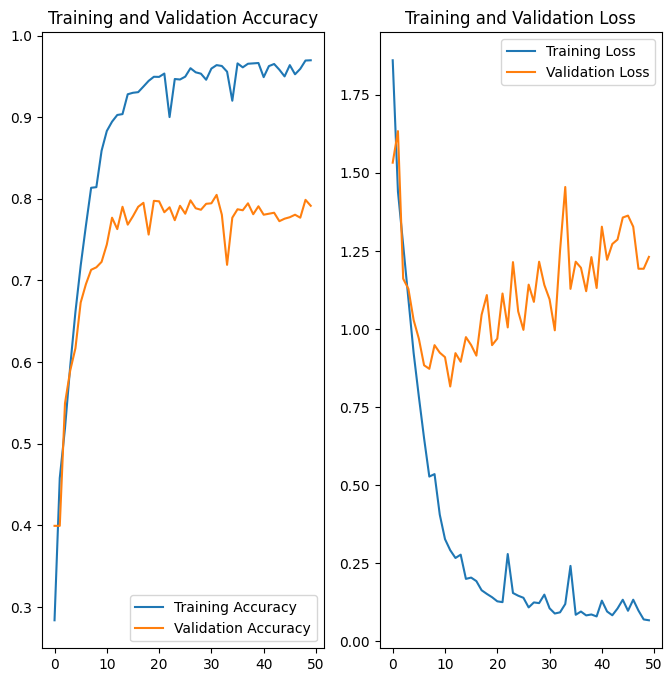

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
## your code goes here 2 - without dropout
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 50
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
206/206 [==============================] - 6s 22ms/step - loss: 1.6543 - accuracy: 0.3647 - val_loss: 1.3893 - val_accuracy: 0.4644
Epoch 2/30
206/206 [==============================] - 5s 23ms/step - loss: 1.3517 - accuracy: 0.4869 - val_loss: 1.2558 - val_accuracy: 0.5125
Epoch 3/30
206/206 [==============================] - 5s 23ms/step - loss: 1.1508 - accuracy: 0.5732 - val_loss: 1.1186 - val_accuracy: 0.6067
Epoch 4/30
206/206 [==============================] - 4s 21ms/step - loss: 0.9946 - accuracy: 0.6344 - val_loss: 1.0509 - val_accuracy: 0.6128
Epoch 5/30
206/206 [==============================] - 5s 22ms/step - loss: 0.8018 - accuracy: 0.7061 - val_loss: 0.8655 - val_accuracy: 0.7046
Epoch 6/30
206/206 [==============================] - 5s 22ms/step - loss: 0.6478 - accuracy: 0.7692 - val_loss: 0.9969 - val_accuracy: 0.6578
Epoch 7/30
206/206 [==============================] - 4s 21ms/step - loss: 0.5509 - accuracy: 0.8079 - val_loss: 0.9627 - val_accuracy: 0.6906

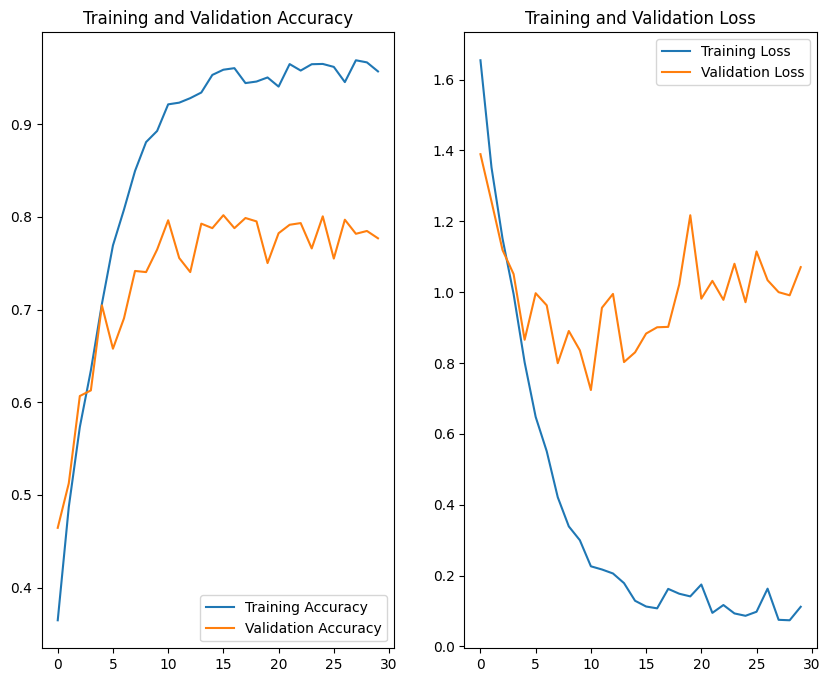

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
## your code goes here 3 - adding dropout after each Conv layer
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
epochs = 50
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
206/206 [==============================] - 9s 30ms/step - loss: 2.0423 - accuracy: 0.2404 - val_loss: 2.0020 - val_accuracy: 0.2061
Epoch 2/30
206/206 [==============================] - 6s 29ms/step - loss: 1.6153 - accuracy: 0.3782 - val_loss: 1.5687 - val_accuracy: 0.4407
Epoch 3/30
206/206 [==============================] - 6s 28ms/step - loss: 1.4061 - accuracy: 0.4700 - val_loss: 1.3809 - val_accuracy: 0.4687
Epoch 4/30
206/206 [==============================] - 6s 30ms/step - loss: 1.2834 - accuracy: 0.5127 - val_loss: 1.2811 - val_accuracy: 0.5088
Epoch 5/30
206/206 [==============================] - 6s 28ms/step - loss: 1.1815 - accuracy: 0.5551 - val_loss: 1.2538 - val_accuracy: 0.5222
Epoch 6/30
206/206 [==============================] - 6s 29ms/step - loss: 1.0715 - accuracy: 0.6043 - val_loss: 1.2199 - val_accuracy: 0.5319
Epoch 7/30
206/206 [==============================] - 6s 28ms/step - loss: 0.9761 - accuracy: 0.6346 - val_loss: 1.1440 - val_accuracy: 0.5787

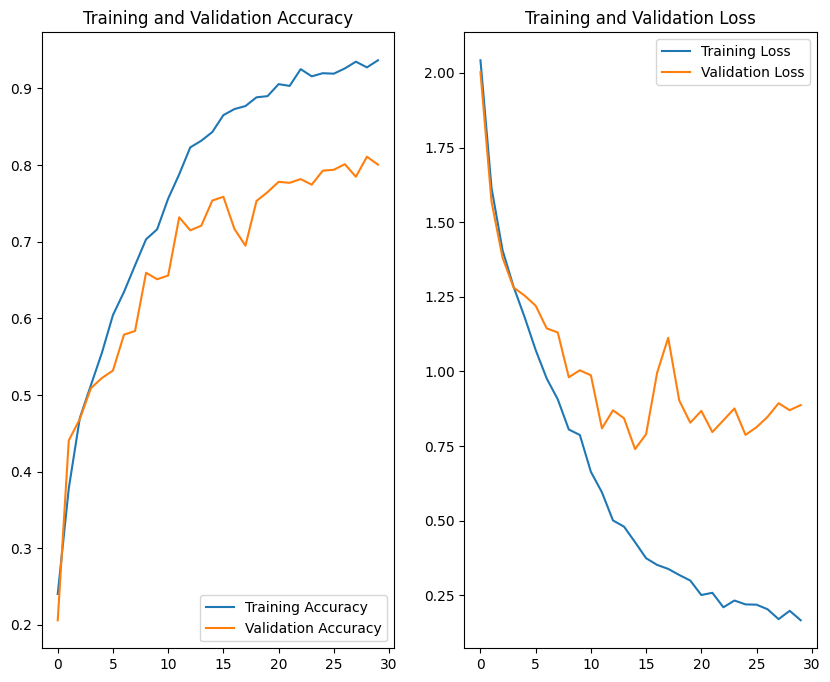

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
## your code goes here 4 - adding one more layer of convulution
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
epochs = 30
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
206/206 [==============================] - 9s 31ms/step - loss: 1.8708 - accuracy: 0.2790 - val_loss: 1.6523 - val_accuracy: 0.4006
Epoch 2/30
206/206 [==============================] - 5s 26ms/step - loss: 1.4856 - accuracy: 0.4268 - val_loss: 1.4554 - val_accuracy: 0.4413
Epoch 3/30
206/206 [==============================] - 6s 27ms/step - loss: 1.3629 - accuracy: 0.4735 - val_loss: 1.3366 - val_accuracy: 0.4875
Epoch 4/30
206/206 [==============================] - 6s 28ms/step - loss: 1.2433 - accuracy: 0.5283 - val_loss: 1.3595 - val_accuracy: 0.4505
Epoch 5/30
206/206 [==============================] - 6s 27ms/step - loss: 1.1324 - accuracy: 0.5732 - val_loss: 1.1034 - val_accuracy: 0.5884
Epoch 6/30
206/206 [==============================] - 5s 26ms/step - loss: 0.9924 - accuracy: 0.6309 - val_loss: 1.0256 - val_accuracy: 0.6219
Epoch 7/30
206/206 [==============================] - 6s 29ms/step - loss: 0.8745 - accuracy: 0.6783 - val_loss: 0.9127 - val_accuracy: 0.6766

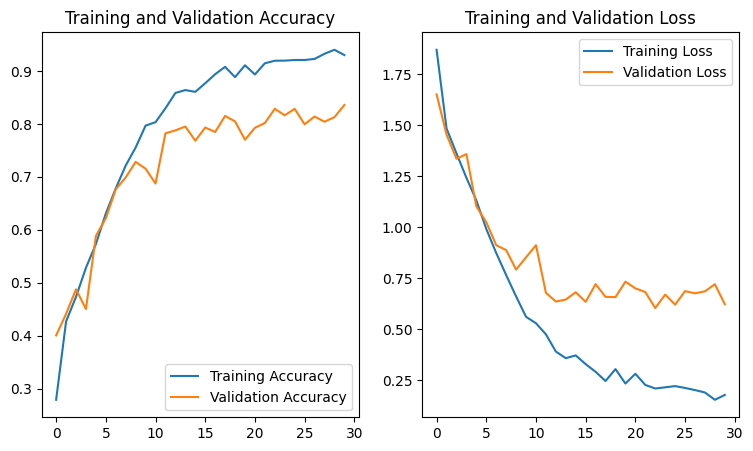

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
## your code goes here 5 - adding one more layer of convulution
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
#with one more layer and a dropout
epochs = 50 # go for 50 epochs
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
206/206 [==============================] - 10s 27ms/step - loss: 1.8987 - accuracy: 0.2550 - val_loss: 1.7725 - val_accuracy: 0.3246
Epoch 2/30
206/206 [==============================] - 5s 25ms/step - loss: 1.5792 - accuracy: 0.3931 - val_loss: 1.7118 - val_accuracy: 0.3137
Epoch 3/30
206/206 [==============================] - 5s 26ms/step - loss: 1.4480 - accuracy: 0.4470 - val_loss: 1.4383 - val_accuracy: 0.4565
Epoch 4/30
206/206 [==============================] - 5s 23ms/step - loss: 1.3532 - accuracy: 0.4800 - val_loss: 1.4113 - val_accuracy: 0.4426
Epoch 5/30
206/206 [==============================] - 5s 26ms/step - loss: 1.2680 - accuracy: 0.5083 - val_loss: 1.2972 - val_accuracy: 0.5009
Epoch 6/30
206/206 [==============================] - 5s 24ms/step - loss: 1.1821 - accuracy: 0.5469 - val_loss: 1.2272 - val_accuracy: 0.5392
Epoch 7/30
206/206 [==============================] - 5s 25ms/step - loss: 1.0995 - accuracy: 0.5849 - val_loss: 1.1592 - val_accuracy: 0.575

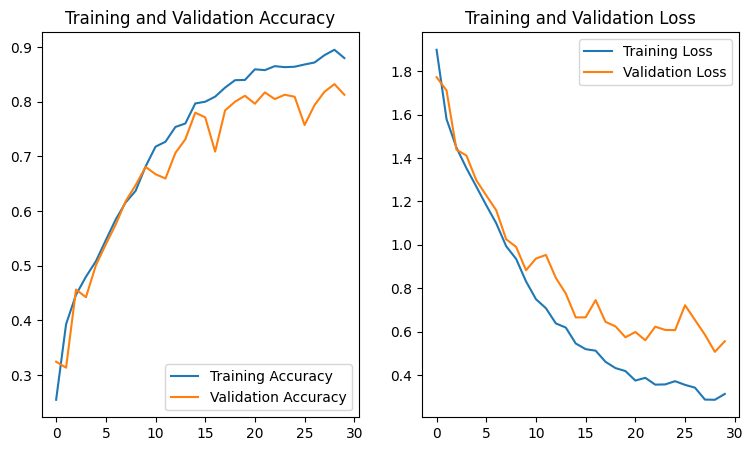

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
## your code goes here 6 - adding one more layer of convulution without dropout
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [80]:
epochs = 50
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
206/206 [==============================] - 8s 28ms/step - loss: 2.0355 - accuracy: 0.1947 - val_loss: 1.7974 - val_accuracy: 0.2754
Epoch 2/40
206/206 [==============================] - 5s 23ms/step - loss: 1.6478 - accuracy: 0.3563 - val_loss: 1.5429 - val_accuracy: 0.3629
Epoch 3/40
206/206 [==============================] - 5s 24ms/step - loss: 1.4679 - accuracy: 0.4273 - val_loss: 1.4632 - val_accuracy: 0.4207
Epoch 4/40
206/206 [==============================] - 5s 25ms/step - loss: 1.4067 - accuracy: 0.4536 - val_loss: 1.4274 - val_accuracy: 0.4608
Epoch 5/40
206/206 [==============================] - 5s 24ms/step - loss: 1.3253 - accuracy: 0.4823 - val_loss: 1.3891 - val_accuracy: 0.4675
Epoch 6/40
206/206 [==============================] - 5s 25ms/step - loss: 1.2544 - accuracy: 0.5101 - val_loss: 1.3678 - val_accuracy: 0.4802
Epoch 7/40
206/206 [==============================] - 5s 25ms/step - loss: 1.2020 - accuracy: 0.5361 - val_loss: 1.2339 - val_accuracy: 0.5125

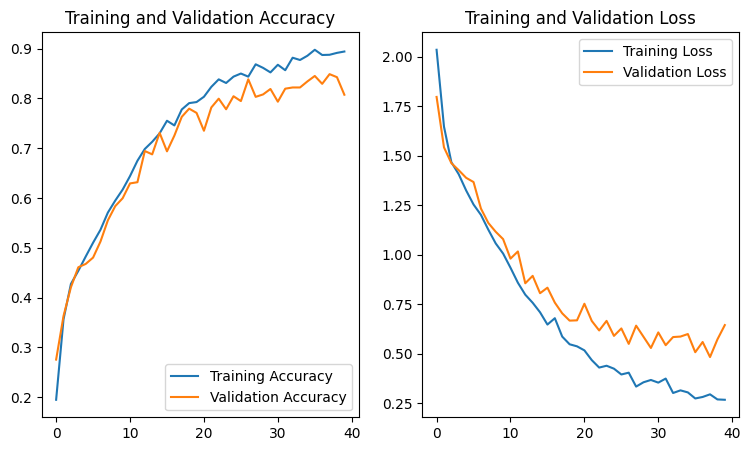

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

